In [367]:
from keras.layers import Input, Flatten, Dense, Conv2D, Conv2DTranspose, Dropout, BatchNormalization, LeakyReLU, Reshape, Activation, Lambda
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf

from PIL import Image

from typing import Tuple, List
from functools import partial

import tensorflow_datasets as tfds

In [238]:
class VariationalAutoEncoder():

  def __init__(self, 
               input_dim: Tuple[int],
               encoder_conv_filters: List[int],
               encoder_conv_kernel_size: List[int],
               encoder_conv_strides: List[int],
               decoder_conv_t_filters: List[int],
               decoder_conv_t_kernel_size: List[int],
               decoder_conv_t_strides: List[int],
               z_dim: int,
               use_batch_norm=False,
               use_dropout=False):

    self.name = "variational_autoencoder"
    self.input_dim = input_dim
    self.encoder_conv_filters = encoder_conv_filters
    self.encoder_conv_kernel_size = encoder_conv_kernel_size
    self.encoder_conv_strides = encoder_conv_strides
    self.decoder_conv_t_filters = decoder_conv_t_filters
    self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
    self.decoder_conv_t_strides = decoder_conv_t_strides
    self.z_dim = z_dim
    self.use_batch_norm = use_batch_norm
    self.use_dropout = use_dropout
    self.n_layers_encoder = len(encoder_conv_filters)
    self.n_layers_decoder = len(decoder_conv_t_filters)

    self._build()
  
  def _build(self):
    self._build_encoder()
    self._build_decoder()
    model_input = self.encoder_input
    model_output = self.decoder(self.encoder_output)

    self.model = Model(model_input, model_output)

  def _build_encoder(self):
    self.encoder_input = x = Input(shape=self.input_dim, name="encoder_input")

    for i in range(self.n_layers_encoder):
      conv_layer = Conv2D(filters=self.encoder_conv_filters[i],
                          kernel_size=self.encoder_conv_kernel_size[i],
                          strides=self.encoder_conv_strides[i],
                          padding="same",
                          name=f"encoder_conv_{i}")

      x = conv_layer(x)
      x = LeakyReLU(name=f"leaky_relu_{i}")(x)

      if self.use_batch_norm:
        x = BatchNormalization()(x)

      if self.use_dropout:
        x = Dropout(p=0.25)(x)

    self.shape_before_flatten = K.int_shape(x)[1:]
    x = Flatten()(x)

    # Instead of outputting just two values - output mean and variance for a normal distribution
    self.mu = Dense(units=self.z_dim, name="mu")(x)
    self.log_var = Dense(units=self.z_dim, name="log_variance")(x)

    self.encoder_mu_log_var = Model(self.encoder_input, (self.mu, self.log_var)) # outputs the values of mu and log_var for a given image 

    # Sample values from every normal distribution (z_dim means, z_dim log_vars -> z_dim points)
    def sampling(args):
      mu, log_var = args
      epsilon = K.random_normal(shape=K.shape(mu), mean=0.0, stddev=1.0)
      return mu + K.exp(log_var / 2) * epsilon

    # self.encoder_output = Dense(units=self.z_dim, name="encoder_output")(x)
    self.encoder_output = Lambda(sampling, name="encoder_output")([self.mu, self.log_var])
    self.encoder = Model(self.encoder_input, self.encoder_output)

  def _build_decoder(self):
    decoder_input = x = Input(shape=(self.z_dim, ), name="decoder_input")
    x = Dense(units=np.prod(self.shape_before_flatten), name="dense_1")(x)
    x = Reshape(self.shape_before_flatten)(x)
    for i in range(self.n_layers_decoder):
      conv_layer = Conv2DTranspose(filters=self.decoder_conv_t_filters[i],
                          kernel_size=self.decoder_conv_t_kernel_size[i],
                          strides=self.decoder_conv_t_strides[i],
                          padding="same",
                          name=f"decoder_conv_t_{i}")
      x = conv_layer(x)
      if i < self.n_layers_decoder - 1:
        x = LeakyReLU()(x)

    decoder_output = Activation("relu", name="relu_activation")(x)
    self.decoder = Model(decoder_input, decoder_output, name="decoder_network")

  def compile(self, optimizer, mse_loss_factor=1):

    def mse_loss(y_true, y_pred):
      """
      Reconstruction / Generative loss - Mean Squared Error
      """
      return K.mean(K.square(y_true - y_pred), axis=[1, 2, 3])
  
    def kl_loss(y_true, y_pred):
      """
      Latent loss
      Kullback-Leibler Divergence - measures how much one probability distribution differs from another.
      In this case, we're measuring how big is the difference between distributions in latent space and 
      a standard normal one. 
      Goal - minimize the distance to make the latent space more dense (points in the latent space will be located close to each other).
      """
      return -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis=1)

    def loss_function(y_true, 
                      y_pred):
      return mse_loss_factor * mse_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    self.model.compile(optimizer=optimizer, loss=loss_function, 
                       metrics=[mse_loss, kl_loss],
                       experimental_run_tf_function=False)

  def fit(self, 
          dataloader, 
          epochs, 
          callbacks_list=[]):
    history = self.model.fit(dataloader.repeat(epochs), epochs=epochs, steps_per_epoch=60000 // dataloader.element_spec[0].shape[0], callbacks=callbacks_list)
    return history 

In [359]:
ds_train = tfds.load(
    'mnist',
    split=['train'],
    shuffle_files=True,
    as_supervised=False,
)

ds_train = ds_train[0]

In [331]:
ds_train = ds_train.map(lambda x: tf.cast(x["image"], tf.float32) / 255.)
ds_train = tf.data.Dataset.zip((ds_train, ds_train))
ds_train = ds_train.batch(64, drop_remainder=True).shuffle(1000)

In [246]:
vae = VariationalAutoEncoder(input_dim=(28, 28, 1),
                               encoder_conv_filters=[32, 64, 64, 64],
                               encoder_conv_kernel_size=[3, 3, 3, 3],
                               encoder_conv_strides=[1, 2, 2, 1],
                               decoder_conv_t_filters=[64, 64, 32, 1],
                               decoder_conv_t_kernel_size=[3, 3, 3, 3],
                               decoder_conv_t_strides=[1, 2, 2, 1],
                               z_dim=2)

vae.compile(
    optimizer=Adam(learning_rate=0.0005),
    mse_loss_factor=5000
)

vae.fit(ds_train, epochs=100)

Train on 937 steps
Epoch 1/100
937/937 [==============================] - 21s 11ms/step - batch: 468.0000 - size: 1.0000 - loss: 273.2305 - mse_loss: 0.0536 - kl_loss: 4.9983
Epoch 2/100
937/937 [==============================] - 10s 11ms/step - batch: 468.0000 - size: 1.0000 - loss: 237.8856 - mse_loss: 0.0464 - kl_loss: 5.8307
Epoch 3/100
937/937 [==============================] - 10s 11ms/step - batch: 468.0000 - size: 1.0000 - loss: 229.3753 - mse_loss: 0.0446 - kl_loss: 6.1385
Epoch 4/100
937/937 [==============================] - 11s 11ms/step - batch: 468.0000 - size: 1.0000 - loss: 224.3430 - mse_loss: 0.0436 - kl_loss: 6.3022
Epoch 5/100
937/937 [==============================] - 10s 11ms/step - batch: 468.0000 - size: 1.0000 - loss: 220.7129 - mse_loss: 0.0429 - kl_loss: 6.4286
Epoch 6/100
937/937 [==============================] - 10s 11ms/step - batch: 468.0000 - size: 1.0000 - loss: 217.8855 - mse_loss: 0.0423 - kl_loss: 6.5424
Epoch 7/100
937/937 [========================

In [292]:
import matplotlib.pyplot as plt 

def decode(z):
  res = vae.decoder.predict((tf.constant([z], dtype=tf.float32)), steps=1)
  res = res * 255.0
  return res.reshape([28, -1])

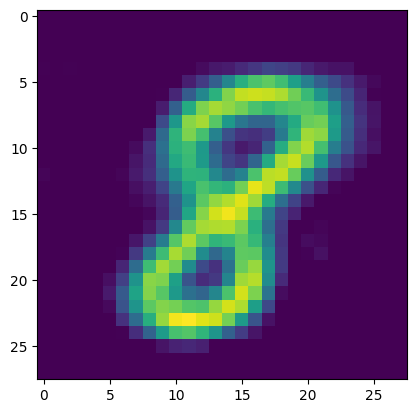

In [335]:
a = decode([1.1, -0.2])
plt.imshow(a)
# print(a.shape)